# Try for obtaining MASC's graph for Magnetar SGR 0526−66

In [1]:
#importamos en primer lugar los modulos que vayamos a usar
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from gammaALPs.base import environs, transfer
from ebltable.tau_from_model import OptDepth

We first import the relevant modules:

In [2]:
m, g = 3.96, 1.01 #sacado del paper de MASC
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [3]:
EGeV = np.logspace(-1., 2.5, 500) #provisional, modificable

For the initial polarization, we'll use the following one:

In [4]:
pin = np.diag((1., 1., 0.))*0.5 #non polarized

Let's generate the Source using the right parameters, in this case, the central galaxy cluster of perseus

In [5]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

In [6]:
ml = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

Now we add propagation module

In [7]:
ml.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=500, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )


ml.add_propagation("IGMF",
                  2, # position of module counted from the source.
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez' # EBL model
                  )

ml.add_propagation("EBL",2, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster

ml.add_propagation("GMF",3, model = 'jansson12', model_sym = 'BSS') # finally, the beam enters the Milky Way Field

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
environs.py:1196 --- INFO: Using inputted chi


Now, we can run the model

In [8]:
px, py, pa = ml.run()
print (pa.shape)

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 3: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 4: <class 'gammaALPs.base.environs.MixIGMFCell'>


(500, 500)


And once we have done this, we can plot the `Photon survival probability` and add the `EBL Conversion`  

Text(0, 0.5, 'Photon survial probability')

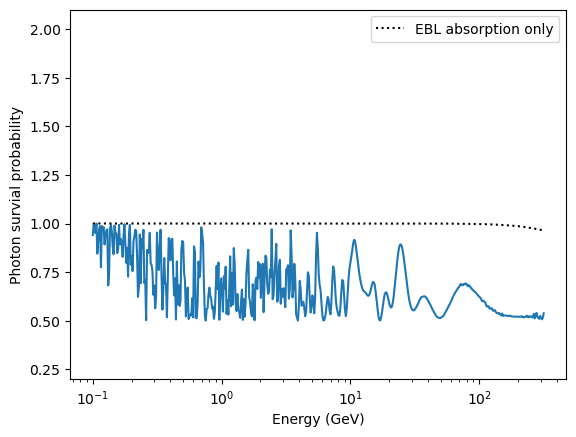

In [9]:
tau = ml.modules["IGMFCell"].t.opt_depth(ml.source.z, ml.EGeV / 1e3)

plt.semilogx(EGeV, px[0] + py[0])

plt.semilogx(ml.EGeV, np.exp(-tau),
           label='EBL absorption only',
           color='k',
           ls=':')

plt.legend()
plt.gca().set_ylim(0.2,2.1)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survial probability')

## Buscamos obtener la siguiente gráfica

<img src="grafica_masc.png" alt="Texto alternativo" style="width:50%; height:auto;">

In [10]:
pa.shape

(500, 500)

In [11]:
#calculamos mediana y STD
mediana = np.median(pa, axis=0)

sigma = np.std(1 - pa, axis=0)

Text(0, 0.5, 'Photon survial probability')

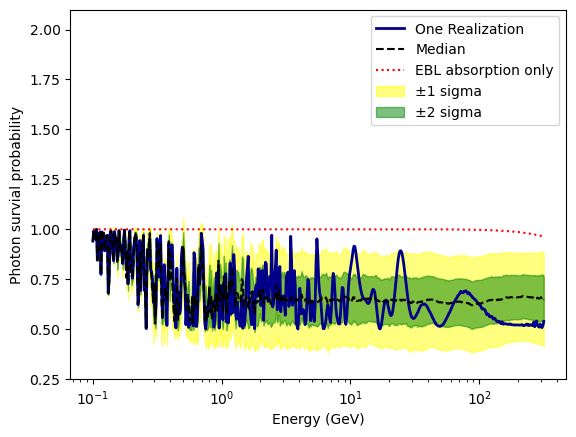

In [12]:
#actualizamos nuestra grafica


p

## Queremos encontrar (y plotear) la relación del campo magnético y la densidad de electrones

Para hacer esto parece necesario usar ICMStructured, así que vamos a ello

In [26]:
ml2 = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
ml2.add_propagation("ICMStructured",
                   0, # position of module counted from the source.
                   B0 = 8.3,  # rms of B field
                   R = 93,
                   theta = 225,
                   theta_rad=False,
                   pa=147,
                   pa_rad=False,
                   n0 = 3.9e-2,  # normalization of electron density
                   n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                   r_abell = 500., # extension of the cluster
                   r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                   r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                   beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                   eta = 0 # scaling of B-field with electron denstiy
                   )
ml2.add_propagation("EBL",1, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster
ml2.add_propagation("GMF",2, model = 'pshirkov', model_sym = 'BSS') # finally, the beam enters the Milky Way Field
px2, py2, pa2 = ml.run()

environs.py: 578 --- INFO: Using inputted chi
environs.py:1196 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 3: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 4: <class 'gammaALPs.base.environs.MixIGMFCell'>


ValueError: x and y must have same first dimension, but have shapes (50,) and (1000,)

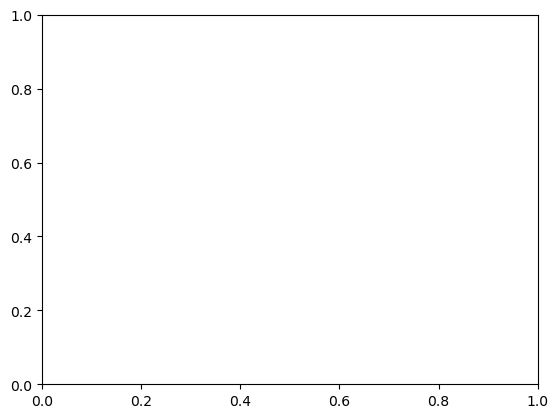

In [27]:
r = ml.modules[0].r
b_r = ml2.modules[0]._Bfield_model.b_r
nel = ml2.modules[0]._nelicm(r)

plt.plot(nel, b_r)